In [32]:
DATA_PATH = '../data/'
LIGHTCURVES_PATH = DATA_PATH + 'lightcurves/'

In [33]:
import pandas as pd
import inputs2

In [34]:
def unique_ids_list(df_lcs):
    return df_lcs.index.get_level_values('ID').unique().format()

def print_num_ids_shape(df_lcs):
    unique_ids = unique_ids_list(df_lcs)
    print('Num IDs: {}  Shape: {}'.format(len(unique_ids), df_lcs.shape))

#### Load Transient Catalog

In [35]:
df_cat = inputs2.load_transient_catalog()

In [36]:
df_cat.head()

,class
ID,
TranID1611101400424116462,Flare
TranID1611101210274176502,HPM
TranID1611101150154137989,HPM
TranID1611091630244128695,HPM
TranID1611091600294129774,CV


#### Load Transient Lightcurves

In [37]:
filename = 'transient_lightcurves_clean.pickle'
indir = LIGHTCURVES_PATH; filepath = indir + filename
df_lcs = pd.read_pickle(filepath)
print_num_ids_shape(df_transient_noclass)

Num IDs: 4869  Shape: (440469, 3)


##### Check that all Lightcurves TransientID's are in Catalog

In [38]:
all_exist = True
transID_cat_list = df_cat.index.unique()
for lcs_id in df_lcs.index.get_level_values('ID').unique():
    all_exist = all_exist and (lcs_id in transID_cat_list)
print('All exist:', str(all_exist))

All exist: True


##### Check that all Catalog TransientID's are in Lightcurves 

In [39]:
all_exist = True
lcs_missing_transientID_list = []
transID_lcs_list = df_cat.index.unique()
for cat_id in df_lcs.index.get_level_values('ID').unique():
    id_exists = (cat_id in transID_lcs_list)
    all_exist = all_exist and id_exists
    if not id_exists: lcs_missing_transientID_list.append(cat_id)
print('All exist:', str(all_exist))
print('Missing: {} Transients'.format(len(lcs_missing_transientID_list)))

All exist: True
Missing: 0 Transients


##### Merge dataframes with inner join

In [54]:
df_merge = df_cat.copy().join(df_lcs.copy().groupby(level=0, axis=0).count(), how='inner')
df_merge.rename(columns={'Mag':'ObsCount'}, inplace=True)

In [63]:
print(df_merge.shape)

(4869, 4)


##### Count number of objects with at least 5 observations

In [76]:
df_merge_filtered = df_merge[df_merge.ObsCount >= 5]
df_merge_filtered.shape[0]

4269

##### Top 10 count of transients by class (with at least 5 observations)

In [77]:
df = df_merge_filtered[['class','ObsCount']].groupby('class').count()
df = df.rename(columns={'ObsCount':'ObjCount'}).sort_values('ObjCount', ascending=False)
df.head(20).transpose()

class,SN,CV,AGN,HPM,Blazar,SN?,Flare,AGN?,Unknown,CV?,Var,Ast?,SN/CV,SN/AGN,YSO,Mira,Blazar?,Flare?,Var?,Ast
ObjCount,1293,862,425,306,237,236,207,130,114,55,47,31,28,23,21,20,19,18,12,12


##### Describe observation count for transients with at least 5 observations

In [78]:
df_lcs[df_lcs.index.get_level_values('ID').isin(df_merge_filtered.index)].groupby(level=0, axis=0).count().describe()

,Mag,Magerr,MJD
count,4269.000000,4269.000000,4269.000000
mean,102.810260,102.810260,102.810260
std,113.786057,113.786057,113.786057
min,5.000000,5.000000,5.000000
25%,14.000000,14.000000,14.000000
50%,48.000000,48.000000,48.000000
75%,166.000000,166.000000,166.000000
max,564.000000,564.000000,564.000000


### Visualize transient light curves

In [380]:
def lightcurve(transID):
    df_lc = df_lcs[df_lcs.TransientID == transID]
    return df_lc

In [373]:
def class_random_ids(klass):
    df_class = df_merge[df_merge.Classification == klass]
    df_class = df_class[(df_class.ObsCount <= 40) & (df_class.ObsCount >= 10)]
    IDs = df_class.TransientID.unique()
    np.random.seed(40)
    rand = np.random.randint(0, IDs.shape[0]-1, 4)
    randIds = IDs[rand]
    return randIds

In [424]:
def plot_lightcurve(lc):
    plot = lc.plot(x='MJD', y='Mag', marker='.', markeredgecolor='black', linestyle='None', legend=False, figsize=(7,7),ylim=(0,30),  yerr='Magerr', elinewidth=0.7)
    plot.set_xlabel('Modified Julian Date')
    plot.set_ylabel('Mag')

In [420]:
top_classes = ['SN', 'CV', 'AGN', 'Blazar']

for i, klass in enumerate(top_classes):
    ids = class_random_ids(klass)
    for idx in ids:
        lc = lightcurve(idx)
        plot_lightcurve(lc)
        plt.savefig('graphs/{}_{}.png'.format(klass, idx))
        plt.close()

Visualize correctly classified in binary task

     Classification          TransientID
3342            HPM  1111031520324144272


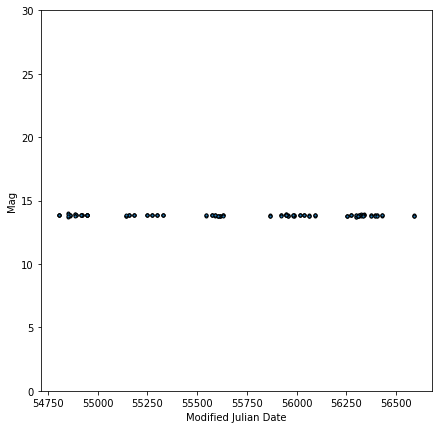

In [425]:
classified_ids = [1111031520324144272]
for ix, _ in enumerate(classified_ids):
    lc = lightcurve(classified_ids[ix])
    print(df_cat[df_cat.TransientID == classified_ids[ix]])
    plot_lightcurve(lc)
#    plt.savefig('graphs/binary/trans_corr_{}.png'.format(classified_ids[ix]))
#    plt.close()

Visualize incorrectly classified in binary task

In [422]:
missclassified_ids = [1509251350694128317, 1603021070274145695, 1404301350644109127, 1607060121174118737]
for ix, _ in enumerate(missclassified_ids):
    lc = lightcurve(missclassified_ids[ix])
    print(df_cat[df_cat.TransientID == missclassified_ids[ix]])
    plot_lightcurve(lc)
    plt.savefig('graphs/binary/trans_incorr_{}.png'.format(missclassified_ids[ix]))
    plt.close()

    Classification          TransientID
709             CV  1509251350694128317
    Classification          TransientID
365             SN  1603021070274145695
     Classification          TransientID
1449             SN  1404301350644109127
    Classification          TransientID
146           AGN?  1607060121174118737
